# SWAST Forecasting Tool

An ensemble of Regression with ARIMA Errors and Facebook Prophet

In [79]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style as style
style.use('ggplot')


import warnings
warnings.filterwarnings('ignore')

check statsmodels version

In [2]:
import statsmodels as sm
print(sm.__version__)

import os

os.getcwd()

0.11.1


'/home/tom/Documents/code/swast-forecast-tool'

In [3]:
from swast_forecast.utility import (pre_process_daily_data, 
                                    default_ensemble,
                                    forecast, 
                                    multi_region_forecast)

Importing plotly failed. Interactive plots will not work.


## Constants

In [4]:
PATH = '../ambo_data/Daily_Responses_5_Years_2019_full.csv'

## Read in the data

In [5]:
clean = pre_process_daily_data(path=PATH, 
                               observation_col='Actual_Value', 
                               index_col='Actual_dt')
clean.head()

ora,BNSSG,Cornwall,Devon,Dorset,Gloucestershire,OOA,Somerset,Trust,Wiltshire
actual_dt,,,,,,,,,
2013-12-30,415.0,220.0,502.0,336.0,129.0,NaN,183.0,2042.0,255.0
2013-12-31,420.0,236.0,468.0,302.0,128.0,NaN,180.0,1996.0,260.0
2014-01-01,549.0,341.0,566.0,392.0,157.0,NaN,213.0,2570.0,351.0
2014-01-02,450.0,218.0,499.0,301.0,115.0,NaN,167.0,2013.0,258.0
2014-01-03,419.0,229.0,503.0,304.0,135.0,NaN,195.0,2056.0,269.0


## Creating and fitting an Ensemble model to a region

The easy way to create an ensemble model is to call the `default_ensemble()` function form the utility module.  This returns the best known forecasting model.

In [6]:
model = default_ensemble()
model

ProphetARIMAEnsemble(order=(1, 1, 3), seasonal_order=(1, 0, 1, 7), prophet_default_alpha={self.alpha})

The code above informs us that the ensemble includes a Regression model with ARIMA errors with parameters (1, 1, 3)(1, 0, 1, 7).  By default a Prophet model will create a 80\% prediction interval 100(1-alpha)

To fit we call the `.fit()` method and pass in a `pd.Series` (or `pd.DataFrame`) that contains the historical observations.  By default you do not need to pass in holidays.  The ensemble will model new years day automatically (via Prophet's holidays function and as a dummy variable in the Regression with ARIMA errors).

In [7]:
#example - fitting Wiltshire - this will take a few seconds.
model.fit(clean['Wiltshire'])

## Forecasting an individual region.

Use the `.predict()` method to make a forecast.  The method takes 3 parameters:

* **horizon**: int - the forecast horizon e.g. 84 days
* **alpha**: float, optional (default=0.05) - a value between 0 and 1 and used to construct a 100(1 - alpha) prediction interval. E.g. alpha=0.2 returns a 80\% interval.  
* **return_all_models**: bool, optional (default=False). If sets to true returns the ensemble prediction AND the Prophet and Regression predictions.

In [8]:
#example 1: predict 7 days ahead - remember we have fitted Wiltshire training data.
forecast_frame = model.predict(horizon=7)
forecast_frame

,yhat,yhat_lower_95,yhat_upper95
ds,,,
2020-01-01,389.033671,352.505593,425.815607
2020-01-02,328.488021,290.757418,366.515376
2020-01-03,332.563272,295.410309,369.306217
2020-01-04,348.733984,311.169968,385.381912
2020-01-05,348.858335,311.470449,387.852766
2020-01-06,335.638559,297.664766,373.524055
2020-01-07,326.682607,289.571873,364.475287


The method returns a `pd.DataFrame` containing mean forecast (yhat) and an upper and lower prediction interval.  The code below demonstrates how to return predictions from both the ARIMA and Prophet models.  We will also return a different prediction interval.

In [9]:
#example 2: predict 7 days ahead, return 80% PI and individual model preds
forecast_frame = model.predict(horizon=7, alpha=0.2, return_all_models=True)
forecast_frame

,yhat,yhat_lower_80,yhat_upper80,arima_mean,arima_lower_80,arima_upper_80,prophet_mean,prophet_lower_80,prophet_upper_80
ds,,,,,,,,,
2020-01-01,389.033671,365.073708,413.998007,381.652918,357.811543,405.494293,396.414423,372.335874,422.501721
2020-01-02,328.488021,304.647595,352.915973,328.893489,304.534189,353.252789,328.082554,304.761001,352.579157
2020-01-03,332.563272,308.409365,356.919382,333.117808,308.470773,357.764844,332.008735,308.347957,356.073919
2020-01-04,348.733984,324.496267,373.244859,347.836168,322.927592,372.744744,349.631799,326.064942,373.744974
2020-01-05,348.858335,325.025791,373.241591,348.568032,323.420965,373.715099,349.148638,326.630617,372.768084
2020-01-06,335.638559,311.551680,360.268066,337.437881,312.072670,362.803092,333.839236,311.030689,357.733040
2020-01-07,326.682607,302.093793,351.864528,330.057359,304.492022,355.622696,323.307855,299.695563,348.106359


## An 'all in one' forecast function

As an alternative to the above the `utility` module contains a convenience function called `forecast`.  This is an all-in-one function.  Just pass in your training data (for a single time series) and horizon.

In [10]:
forecast(clean['Wiltshire'], 
         horizon=365, 
         alpha=0.2,
         return_all_models=False)


,yhat,yhat_lower_80,yhat_upper80
ds,,,
2020-01-01,389.033671,366.168297,412.777670
2020-01-02,328.488021,303.657088,352.441487
2020-01-03,332.563272,308.118102,356.503700
2020-01-04,348.733984,324.284516,373.301882
2020-01-05,348.858335,323.421741,372.696029
...,...,...,...
2020-12-26,362.611323,331.249568,393.305070
2020-12-27,362.719865,331.443007,393.682663
2020-12-28,349.847016,318.506818,380.472323


## Forecasting multiple regions in one go.

If there are multiple regions to forecast put all of the training data into the same frame (see `clean`) and pass this to the `multi_region_forecast()` function from the `utility` module.

This is an efficient function as it runs the forecasts in parrallel across your CPU cores.  E.g. if you have a 4 cores then 4 regions will be forecast simultaneously.  This will reduce model run time (assuming you have more than one Core).

In [60]:
#note depending on your machine this will take 20 seconds to run.
forecasts = multi_region_forecast(y_train=clean, horizon=84, return_all_models=True)

forecasts2 = multi_region_forecast(y_train=clean, horizon=84, alpha=0.2, return_all_models=True)

In [61]:
#the function returns a list of pd.DataFrame's
type(forecasts)

list

In [68]:
#results for BNSSG
forecasts2[0]

,yhat,yhat_lower_80,yhat_upper80,arima_mean,arima_lower_80,arima_upper_80,prophet_mean,prophet_lower_80,prophet_upper_80
ds,,,,,,,,,
2020-01-01,667.046404,635.136422,697.081112,663.916904,633.229241,694.604566,670.175905,637.043603,699.557659
2020-01-02,545.976607,513.988122,578.110656,558.273951,526.284179,590.263723,533.679263,501.692064,565.957588
2020-01-03,553.843168,521.285073,585.603734,566.038110,533.642009,598.434210,541.648225,508.928137,572.773257
2020-01-04,588.031241,556.901450,619.779167,597.747843,565.078191,630.417494,578.314640,548.724709,609.140840
2020-01-05,579.761990,548.011943,611.492120,590.844532,557.823136,623.865929,568.679448,538.200751,599.118312
...,...,...,...,...,...,...,...,...,...
2020-03-20,552.253334,511.443558,594.948318,570.000036,518.013124,621.986949,534.506631,504.873992,567.909687
2020-03-21,586.995222,545.513832,628.981634,600.949030,548.752018,653.146041,573.041414,542.275645,604.817228
2020-03-22,579.787578,537.318056,622.750751,594.355207,541.948945,646.761469,565.219949,532.687168,598.740033


In [63]:
#results for Cornwall is at index 1 etc.
forecasts[1]

,yhat,yhat_lower_95,yhat_upper95,arima_mean,arima_lower_95,arima_upper_95,prophet_mean,prophet_lower_95,prophet_upper_95
ds,,,,,,,,,
2020-01-01,317.561603,285.558749,349.047117,318.514226,286.262225,350.766228,316.608979,284.855274,347.328006
2020-01-02,252.695551,219.659067,284.409055,255.822685,222.887571,288.757799,249.568417,216.430564,280.060311
2020-01-03,255.669320,223.641598,288.516181,259.330392,226.073069,292.587715,252.008248,221.210126,284.444647
2020-01-04,271.179998,238.016354,304.683238,274.456703,241.127584,307.785821,267.903293,234.905124,301.580654
2020-01-05,274.010956,241.531213,306.802319,278.078459,244.685024,311.471894,269.943453,238.377402,302.132744
...,...,...,...,...,...,...,...,...,...
2020-03-20,252.338834,217.874390,288.218476,261.320057,222.915907,299.724206,243.357611,212.832872,276.712747
2020-03-21,268.410089,233.315668,303.887977,276.345084,237.876248,314.813921,260.475094,228.755088,292.962033
2020-03-22,271.859837,237.990601,306.949844,279.943529,241.410162,318.476896,263.776144,234.571040,295.422793


In [102]:
def forecast_and_plot(y_train, horizon=84):


    alphas = [0.05, 0.2]
    
    forecasts = []
    for alpha in alphas:
        result = forecast(y_train, horizon, alpha=alpha)
        forecasts.append(result)


    fig, ax = plt.subplots(1,1, figsize=(12,9))
    ax.plot(y_train.iloc[-365:])
    ax.plot(forecasts[0]['yhat'])

    ax.fill_between(forecasts[1].index, forecasts[1]['yhat'], forecasts[1]['yhat_upper80'], 
                        alpha=0.2,
                        label='80% PI', color='yellow');

    ax.fill_between(forecasts[1].index, forecasts[1]['yhat'], forecasts[1]['yhat_lower_80'], 
                        alpha=0.2,
                        label='80% PI', color='yellow');
    
    ax.fill_between(forecasts[0].index, forecasts[1]['yhat_upper80'], forecasts[0]['yhat_upper95'], 
                        alpha=0.2,
                        label='95% PI', color='purple');

    ax.fill_between(forecasts[0].index, forecasts[1]['yhat_lower_80'], forecasts[0]['yhat_lower_95'], 
                        alpha=0.2,
                        label='95% PI', color='purple');



    ax.legend(['train', 'point forecast', '80%PI', '_ignore','_ignore', 
                       '95%PI'], loc=2);

    #ax.plot(forecasts[0]['yhat_upper95'], color='black')
    #ax.plot(forecasts[0]['yhat_lower_95'], color='black')

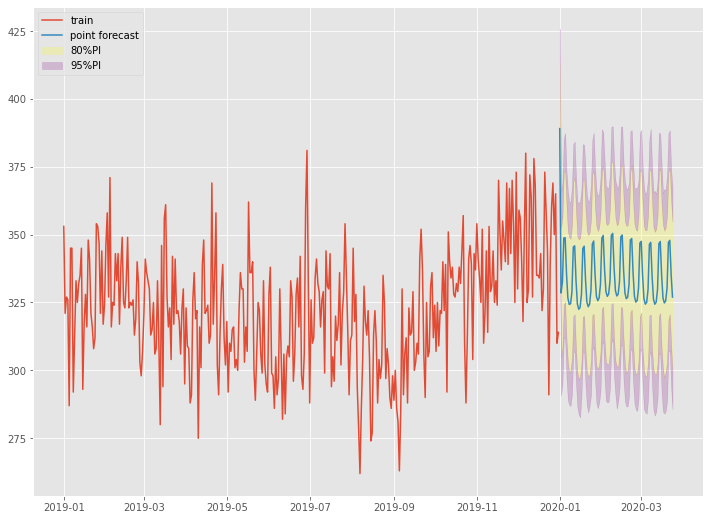

In [103]:
forecast_and_plot(clean['Wiltshire'])

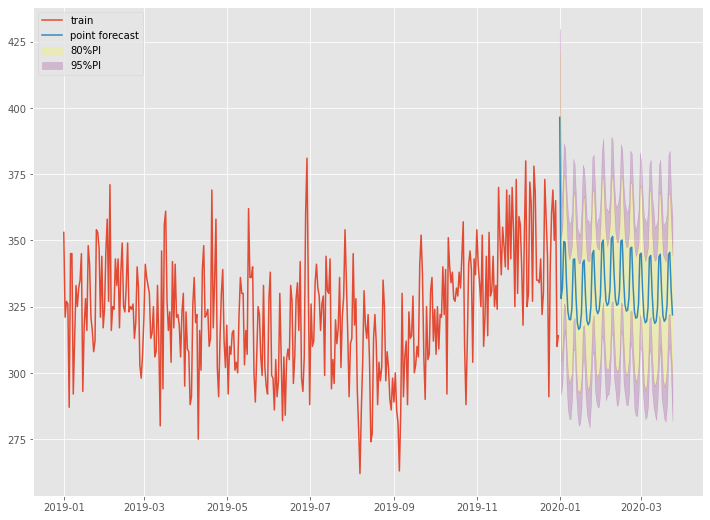

In [111]:
forecast_p_and_plot(clean['Wiltshire'], model='prophet')

In [109]:
def forecast_p_and_plot(y_train, model='arima', horizon=84):


    alphas = [0.05, 0.2]
    
    forecasts = []
    for alpha in alphas:
        result = forecast(y_train, horizon, alpha=alpha, return_all_models=True)
        forecasts.append(result)


    fig, ax = plt.subplots(1,1, figsize=(12,9))
    ax.plot(y_train.iloc[-365:])
    ax.plot(forecasts[0][f'{model}_mean'])

    ax.fill_between(forecasts[1].index, forecasts[1][f'{model}_mean'], forecasts[1][f'{model}_upper_80'], 
                        alpha=0.2,
                        label='80% PI', color='yellow');

    ax.fill_between(forecasts[1].index, forecasts[1][f'{model}_mean'], forecasts[1][f'{model}_lower_80'], 
                        alpha=0.2,
                        label='80% PI', color='yellow');
    
    ax.fill_between(forecasts[0].index, forecasts[1][f'{model}_upper_80'], forecasts[0][f'{model}_upper_95'], 
                        alpha=0.2,
                        label='95% PI', color='purple');

    ax.fill_between(forecasts[0].index, forecasts[1][f'{model}_lower_80'], forecasts[0][f'{model}_lower_95'], 
                        alpha=0.2,
                        label='95% PI', color='purple');



    ax.legend(['train', 'point forecast', '80%PI', '_ignore','_ignore', 
                       '95%PI'], loc=2);

    #ax.plot(forecasts[0]['yhat_upper95'], color='black')
    #ax.plot(forecasts[0]['yhat_lower_95'], color='black')